In [1]:
from pyaudi import gdual_double, gdual_vdouble
import pyaudi as pa 
import numpy as np
# import chaospy as cp 
import seaborn
# seaborn.set_style('whitegrid')
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D
print(plt.style.available)
plt.style.use("seaborn-whitegrid")

from Utils.boxgrid import boxgrid
import Utils.DA as da
from Utils.RK4 import RK4
from scipy.integrate import odeint 
# from Utils.autograd_adjoint import odeint 

['bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark-palette', 'seaborn-dark', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'seaborn', 'Solarize_Light2', 'tableau-colorblind10', '_classic_test']


# Goal
Compare forward sensitivity using DA+RK4 implementation with adjoint sensitivity, demostrating that they indeed produce the same information. 

In [2]:
# Problem Data 
def dynamics(x, t, a, u=lambda t,x,a: 0, sqrt=pa.sqrt):
    dx = np.zeros_like(x, dtype=type(a))
    dx[0] = x[1]
    dx[1] = -a*x[1]*sqrt(1e-5+x[1]**2) + u(t,x,a)
    return dx 

def jacobian(x, a):
    return np.array([[0, 1, 0, 0],[0, -2*a*pa.sqrt(1e-5+x[1]**2), -x[1]*pa.sqrt(1e-5+x[1]**2), 1], [0,0,0,0], [0,0,0,0]])

tf = 3
t = np.linspace(0, tf, 300)

x0 = [13, -5.5, 0, 0] 
a = 0.09




Differential algebra solution

In [3]:
A = pa.gdual_double(a, 'a', 2)
X0 = da.make(x0, ['x1','x2', 'a', 'u'], 2)
du = pa.gdual_double(0, 'u', 2)


X = RK4(dynamics, X0, t, args=(A, lambda t,x,a: du))
names = ['x1','x2','a', 'u']
gradient = da.jacobian(X[-1], names)
stm = [da.jacobian(x, names) for x in X] # change in [x1, x2] wrt [x10, x20, a, u]
hessian = [da.hessian(x, names) for x in X[-1]]
print(stm[-1])
# print(hessian[1])

[[ 1.          1.20724352 38.60336135  2.70724361]
 [ 0.          0.16193745 14.69582645  1.56435208]
 [ 0.          0.          1.          0.        ]
 [ 0.          0.          0.          1.        ]]


Adjoint solution

[[ 1.          1.20724084 38.60349948  2.70724113]
 [ 0.          0.16193673 14.69585532  1.56435055]]


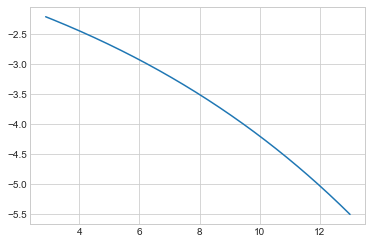

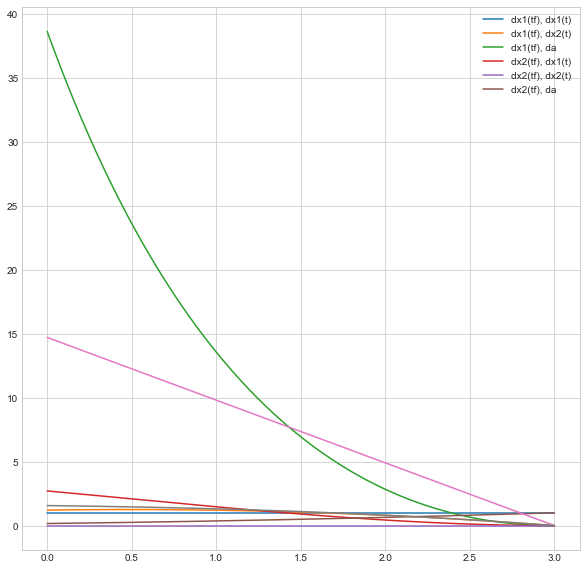

In [4]:
from scipy.interpolate import interp1d 

x = da.const(X, array=True)
x_interp = interp1d(t, x, axis=0, bounds_error=False, fill_value=(x[0],x[-1]))
plt.plot(x.T[0],x.T[1])
def adjoint_dyn(p, t, X, J,):
    x = X(t)
    A = J(x)
    dp = -A.T.dot(p)
    return dp

J0 = []
P0 = np.eye(4)[:2]
plt.figure(figsize=(10,10))
for p0 in P0:
    Y = odeint(adjoint_dyn, p0, t[::-1], args=(x_interp, lambda x: jacobian(x,a),))
    plt.plot(t, Y[::-1])
    J0.append(Y[-1])
J0 = np.array(J0)
print(J0)

plt.legend(["dx1(tf), dx1(t)", "dx1(tf), dx2(t)", "dx1(tf), da","dx2(tf), dx1(t)", "dx2(tf), dx2(t)", "dx2(tf), da"])
plt.show()

In [5]:
print(np.max(np.abs(gradient[:2]-J0)))
assert np.allclose(gradient[:2], J0, rtol=1e-1, atol=1e-2), "Forward and Adjoint Sensitivities do not match!"


0.00013813052288469407


Determine the control costate with respect to the first state, i.e. $J = x_1$

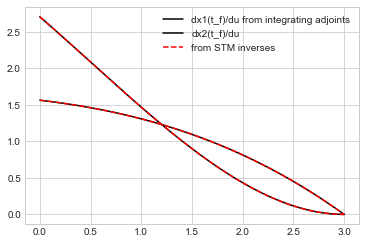

In [6]:
from scipy.integrate import cumtrapz
# This recovers the costates from STM 
dJdx = [[1, 0, 0, 0],[0,1,0,0]]
stmi = [np.linalg.inv(st) for st in stm]
stmf = stm[-1]
C = np.dot(dJdx, stmf)
p1 = np.array([np.dot(C, si) for si in stmi])

# p1 = [dx1/dx; dx2/dx]
dfdu = [0, 1, 0, 0]
# pu1 =  dx1(t_f)/du
pu1 =np.array( [np.trapz(x=t[i:], y=p1[i:,0,1]) for i in range(t.size)])  # Guaranteed to be correct
pu1_= -cumtrapz(x=t[::-1], y=np.squeeze(p1[::-1,0,1]), initial=0)[::-1] # so many weird flips required 
# Since integration is from tf to t, time and costate need to be reversed. Then, to plot against t, it must be reversed
# The negative sign is because pu1 is integrating forward, while pu1_ is integrating backward 
pu2 = np.array([np.trapz(x=t[i:], y=p1[i:,1,1]) for i in range(t.size)])

plt.figure()
plt.plot(t, pu1, 'k', label="dx1(t_f)/du from integrating adjoints")
# plt.plot(t, pu1_,'o')
plt.plot(t, pu2, 'k', label="dx2(t_f)/du")
plt.plot(t, p1[:, 0, 3], 'r--', label="from STM inverses")
plt.plot(t, p1[:, 1, 3], 'r--')

plt.legend()
plt.show()

In conclusion, we can obtain the backward sensitivities to changes in state, parameters, and control from the state transition matrices. 

# Terminal Point Control

Any (first order) "terminal point" controller$^1$, takes the form 
\begin{align}
\Delta u =  \frac{\Delta J}{\lambda_u} =\frac{\lambda_x^T\Delta x}{\lambda_u} 
\end{align}
where $\lambda_q(t) \triangleq \frac{\partial J(x(t_f))}{\partial x(t_f)}\frac{\partial x(t_f)}{\partial q(t)} $. This can also be written in terms of the first order state transtion matrix 
\begin{align}
\lambda_x(t) = \frac{\partial J(x_f)}{\partial x_f}\Phi(t_f)\Phi^{-1}(t) \\
\Delta u =  \frac{\Delta x^T\left( \frac{\partial J}{\partial x}\Phi(t_f)\Phi^{-1}(t)\right)}{\lambda_u} 
\end{align}

Note the following general relationship between adjoint and forward sensitvity
\begin{align}
\lambda_x(t) &= \Phi(t_f)\Phi^{-1}(t) \\
\Phi(t) &= \lambda^{-1}(t)\lambda(t_0)
\end{align}

The question is, should expand the state to second order in control, then expand the objective to first order? Or expand states linear function of control, and set second variation of objective to zero? Expanding both to second order results in cubic terms? Oh shit... just drop them

1. i.e., one that seeks to drive the variation in the Mayer objective to zero despite small variations in state/parameters from the nominal

In [7]:
# Use any reference traj, select a nearby initial condition, and use the TPC to drive it to the same terminal condition at tf. 
from scipy.interpolate import interp1d 

class TPC:
    def __init__(self, t, x, u, a, px, pu):
        self.t = t
        self.x = interp1d(t, x, axis=0, bounds_error=False, fill_value=(x[0],x[-1]))
        self.u = interp1d(t, u, axis=0, bounds_error=False, fill_value=(u[0],u[-1]))
        self.pu = interp1d(t, pu, axis=0, bounds_error=False, fill_value=(pu[0],pu[-1]))
        self.px = interp1d(t, px, axis=0, bounds_error=False, fill_value=(px[0],px[-1]))
        self.a = a

        
    def __call__(self, t, x, a):
        
        px = self.px(t)
        pu = self.pu(t)
        if np.abs(pu) < 1e-2:
            pu = np.sign(pu)*1e-2
        if pu == 0:
            pu = 1.0e6
            
        if np.ndim(x) == 1 and np.ndim(a) == 0:  # Scalar scenario
            dx = np.append(x-self.x(t), a-self.a)
            return self.u(t) - np.dot(dx, px)/pu
        
        else:
            if np.ndim(x) > 1:
                dx = x-self.x(t)[:,None]
            else:
                dx = x-self.x(t)
                
            da = a - self.a  # doesn't matter if a is an array or scalar 
            return self.u(t) - (px[-1]*da + np.dot(px[:-1], dx))/pu
 


In [8]:
def Obj(xf):
#     return xf[0]**2 + xf[1]**2  # match the manifold
#     return xf[0]  # match position
#     return xf[1]  # match velocity 
#     return xf[0]*xf[1]
    return xf[0] + xf[1]

Xf = da.make([x[-1,0],x[-1,1], a, 0], names, 2)
dJdx = da.gradient(Obj(Xf), names)
Jxx = da.hessian(Obj(Xf), names)
C = np.dot(dJdx, stmf)
px = np.array([np.dot(C, si) for si in stmi])
# pu1 = np.array( [np.trapz(x=t[i:], y=px[i:, 1]) for i in range(t.size)])
pu = px[:,3]
# plt.plot(t, pu1, label='Adjoint')
# plt.plot(t, pu, '--', label='STM based')
# plt.legend()
controller = TPC(t, x[:,:2], np.zeros_like(t), a, 1*px[:,:3], pu)  # The costates passed here determine the objective 
sat_controller = lambda t,x,a: np.clip(controller(t,x,a), -3, 3)

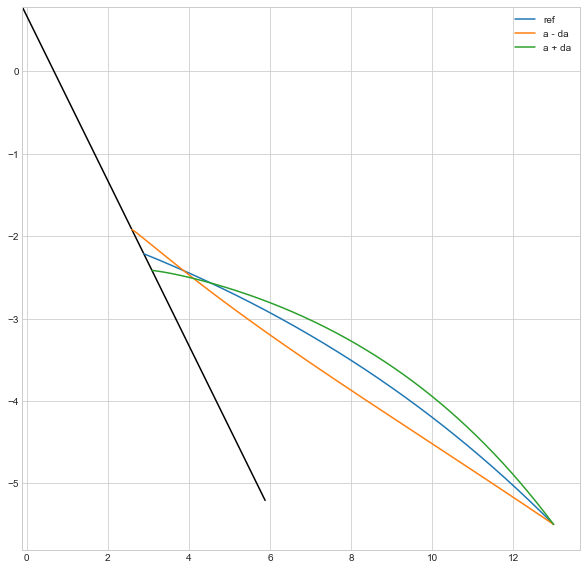

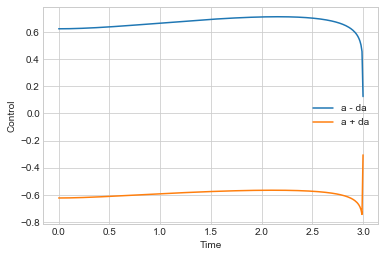

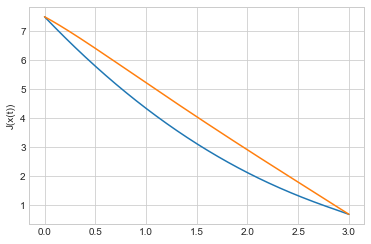

In [9]:
# Lets try just initial condition uncertainty, and just parametric uncertainty 

# Parametric Uncertainty 

plt.figure(1, figsize=(10,10))
plt.plot(x.T[0], x.T[1], label='ref')

X,Y = np.meshgrid(x[-1,0] + np.linspace(-1,1)*3,x[-1,1] + np.linspace(-1,1)*3)
plt.contour(X, Y, Obj([X,Y]), [Obj(x[-1])], colors='k',alpha=1)

for delta_a, label in zip([-0.05,  0.05], ["-","+"]):
    xnew = odeint(dynamics, x0[:2], t, args=(a+delta_a, sat_controller))
    unew = [sat_controller(ti, xi, a+delta_a) for ti,xi in zip(t,xnew)]

    plt.figure(1)
    plt.plot(xnew.T[0], xnew.T[1], label='a {} da'.format(label))
    plt.legend()

    plt.figure(2)
    plt.plot(t, unew, label='a {} da'.format(label))
    plt.xlabel('Time')
    plt.ylabel('Control')
    plt.legend()
    
    plt.figure(3)
    plt.plot(t, Obj(xnew.T))
    plt.ylabel("J(x(t))")

plt.show()

Even for this toy problem with mild drag-like nonlinearity, the linearization results in poor performance unless additional gain is introduced. Of course, performance can also be enhanced by using a different monotonic independent variable, but this is problem dependent and not always possible. Another way we can improve performance in differentiable systems is to include second order sensitivities. 

(299, 2, 500)


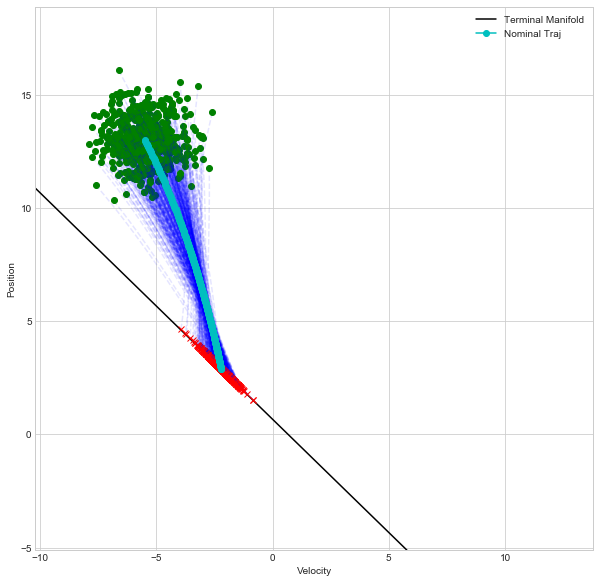

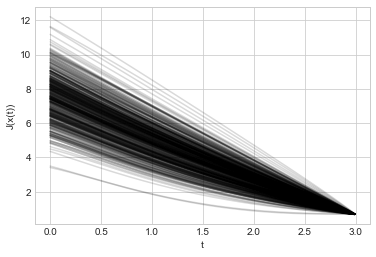

In [10]:

plt.figure(1, figsize=(10,10))


X,Y = np.meshgrid(x[-1,0] + np.linspace(-1,2)*8,x[-1,1] + np.linspace(-1,2)*8)
plt.contour(Y, X, Obj([X,Y]), [Obj(x[-1])], colors='k',alpha=1)
plt.plot(0,0,'k', label="Terminal Manifold") # Just for the label

x0_mc = np.random.multivariate_normal(x0[:2], np.diag([1,1]), 500).T
x_mc = RK4(dynamics, x0_mc, t, args=(a, sat_controller, np.sqrt))[:-1]
print(x_mc.shape)

for xnew in np.transpose(x_mc, (2,0,1)):
    plt.figure(1)
    plt.plot(xnew.T[1], xnew.T[0], 'b--', alpha=0.1)
    plt.plot(xnew[0,1], xnew[0,0], 'go') # IC
    plt.plot(xnew[-1,1], xnew[-1,0], 'rx')  # FC


    plt.figure(3)
    plt.plot(t[:-1], Obj(xnew.T), 'k',alpha=0.15)
    plt.ylabel("J(x(t))")
    plt.xlabel('t')
    
#     plt.figure(2)
#     plt.plot(t, unew)
#     plt.xlabel('Time')
#     plt.ylabel('Control')
plt.figure(1)
plt.plot(x.T[1], x.T[0], 'c-o', label='Nominal Traj')
plt.ylabel("Position")
plt.xlabel("Velocity")
plt.legend()
plt.show()

# Higher Order Neighboring Solutions

- Use map inversion techniques to generate higher order analogues of the adjoint sensitivity
- Solve for the control update as a polynomial root or as a linear function

In [67]:
names = ['X1','X2','A', 'U']
pvars = np.array(["p{}".format(i) for i in range(len(names))])
Isort = np.argsort(["p2", "p3", "p0", "p1"])
# pvars = pvars[Isort]
pzero = 0*np.sum(da.make(np.zeros((4,)), pvars, 2, True))

X0 = da.make(x0, names, 2)
X0 += np.zeros_like(X0)*np.sum(X0)  # This guarantees each DA has all the variables, a requirement for map inversion later 
X = RK4(dynamics, X0, t, args=(X0[2], lambda t,x,a: X0[3]))

x = da.const(X, array=True)

J = Obj(X[-1])
dJ = da.differentiate(J, names)

M = X[-1]-x[-1] # np.zeros_like(x[-1])*np.sum(X0)   
# P = np.array([da.differentiate(xi, names) for xi in X[-1]])

In [68]:
print(M)
Mi = pa.invert_map(M)  # the change in initial state/parameters/control as a function of final state/parameter/control 
print(Mi)
# P[-1]

[-49.5*dA*dU-49.5*dA*dX2+136.125*dA+dX1-1497.38*dA**2+4.5*dU+3*dX2
 -49.5*dA*dU-33*dA*dX2+90.75*dA-1497.38*dA**2+3*dU+dX2 dA dU]
[dp2-6.52473e-018*dp3, dp3, dp0+136.125*dp2-3.22974e-016*dp3**2+3.22974e-016*dp1*dp3+1497.38*dp2**2-3*dp1+49.5*dp2*dp3-49.5*dp1*dp2+4.5*dp3, 3.22974e-016*dp3**2-2.15316e-016*dp1*dp3-3*dp3-49.5*dp2*dp3+33*dp1*dp2-1497.38*dp2**2-90.75*dp2+dp1]


In [79]:
# Timing, compare map inversion for 1/2/3 order expansions with the matrix inversions of first order 
import time 

t0 = time.time()
stm = [da.jacobian(x, names) for x in X]
stmi = [np.linalg.inv(st) for st in stm]
t_stm = time.time()
print("STM differentiation and matrix inversion: {:.2f} s".format(t_stm-t0))

for order in [2]:
    X0 = da.make(x0, names, order)
    X0 += np.zeros_like(X0)*np.sum(X0)  # This guarantees each DA has all the variables, a requirement for map inversion later 
    X = RK4(dynamics, X0, t, args=(X0[2], lambda t,x,a: X0[3]))

    x = da.const(X, array=True)
    dX = X-x
    
    t0 = time.time()
    Mi = np.array([pa.invert_map(M) for M in dX])
    tf = time.time()

    if False:
        print(M[0].symbol_set)
        print(Mi[0][0].symbol_set)

        # The use of Isort here is because of the above ordering of inverse variables (p)
        # which corresponds to the sorted DA vars 
        print(stmi[-1])
        print(da.jacobian(Mi[-1], pvars)[Isort])
    print(Mi[0])
    print(da.jacobian(Mi[0], pvars)[Isort])

#     print(Mi[-1])
    print("Map inversion, order={}: {:.2f} s".format(order, tf-t0))

STM differentiation and matrix inversion: 0.01 s
[dp2 dp3 dp0 dp1]
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
Map inversion, order=2: 0.22 s


In [43]:
# Mi[1][3].subs('du', 0)
# M[0].symbol_set
(Mi[1][0] + pzero).symbol_set

['p0', 'p1', 'p2', 'p3']